In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import subsample_stellar_populations, get_velocity_profile, get_velocity_evolution, oh_to_12pluslog
from src.plots.utils import weighted_median
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
names = [
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin-0p8",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin-0p6",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin-0p4",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin-0p2",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin+0",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin+0p2",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin+0p4",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin+0p6",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/gsebetaphiin+0p8"
]
outputs = [vice.output(name) for name in names]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

/var/folders/26/nqb98q9x5_q6brmqy4v21dqm0000gp/T/ipykernel_19843/3655878877.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


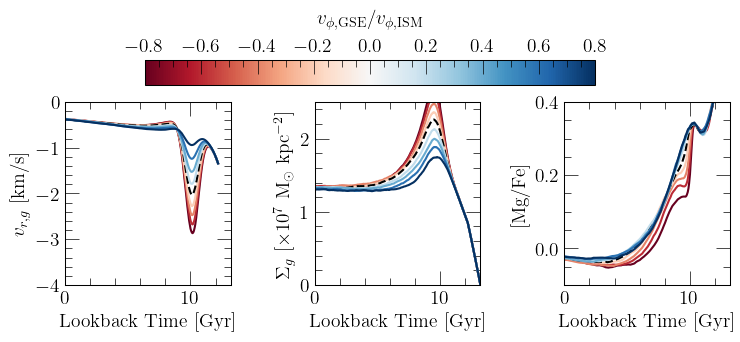

In [3]:
COLORMAP = "RdBu"
BETAPHIIN = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]

fig = plt.figure(figsize = (7.5, 3.5))
axes = []
for i in range(3):
    axes.append(fig.add_subplot(131 + i))
    axes[i].set_xlabel(r"Lookback Time [Gyr]")
    axes[i].set_xlim([0, 13.2])
axes[0].set_ylabel(r"$v_{r,g}$ [km/s]")
axes[1].set_ylabel(r"$\Sigma_g$ [$\times 10^7$ M$_\odot$ kpc$^{-2}$]")
axes[2].set_ylabel(r"[Mg/Fe]")
# for i in range(2): axes[i].set_yscale("log")
# axes[0].yaxis.set_major_formatter(fsf("%g"))
# axes[0].yaxis.set_minor_formatter(fsf("%g"))
# axes[1].set_yscale("log")
# axes[0].set_ylim([0.3, 5])
axes[0].set_ylim([-4, 0])
axes[1].set_ylim([0, 2.5])
axes[2].set_ylim([-0.1, 0.4])

norm = plt.Normalize(vmin = -0.8, vmax = 0.8)
cmap = plt.cm.ScalarMappable(cmap = COLORMAP, norm = norm)
cbar_ax = fig.add_axes([0.2, 0.8, 0.6, 0.1])
cbar = plt.colorbar(cmap, cax = cbar_ax, orientation = "horizontal", location = "top")
cbar.set_label(r"$v_{\phi,\text{GSE}} / v_{\phi,\text{ISM}}$", labelpad = 10)
cbar.set_ticks([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])

def plot_timeevol(ax_v, ax_sigma, ax_mgfe, output, radius = 8, zone_width = 0.1, **kwargs):
    lookback, vgas = get_velocity_evolution(output, radius, zone_width = zone_width)
    ax_v.plot(lookback, vgas, **kwargs)
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    lookback = zone.history["lookback"]
    area = np.pi * ((radius + zone_width)**2 - radius**2)
    sigma_g = [m / (area * 1.0e7) for m in zone.history["mgas"]]
    ax_sigma.plot(lookback, sigma_g, **kwargs)
    ax_mgfe.plot(lookback[5:], zone.history["[mg/fe]"][5:], **kwargs)

for i in range(len(outputs)):
    kwargs = {}
    if BETAPHIIN[i]:
        kwargs["c"] = cmap.to_rgba(BETAPHIIN[i])
    else:
        kwargs["c"] = named_colors()["black"]
        kwargs["linestyle"] = "--"
    plot_timeevol(*axes, outputs[i], **kwargs)

# negative_log(axes[0])
plt.tight_layout()
plt.subplots_adjust(top = 0.7)
cbar_ax.set_position([
    0.2,
    axes[0].get_position().y1 + 0.05,
    0.6,
    0.07
])
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./trajectory-comp/solar-annulus-evol.%s" % (ext), **kwargs)
plt.show()

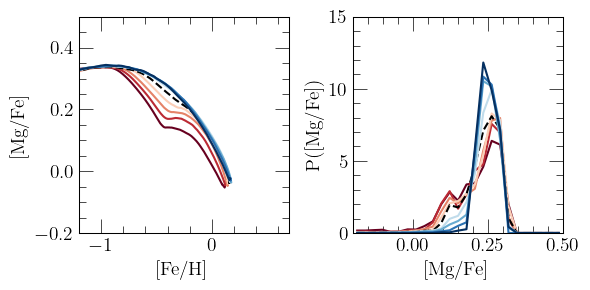

In [4]:
COLORMAP = "RdBu"
BETAPHIIN = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]

fig = plt.figure(figsize = (6, 3))
axes = []
for i in range(2):
    axes.append(fig.add_subplot(121 + i))
axes[0].set_xlabel(r"[Fe/H]")
axes[0].set_ylabel(r"[Mg/Fe]")
axes[1].set_xlabel(r"[Mg/Fe]")
axes[1].set_ylabel(r"P([Mg/Fe])")
axes[0].set_xlim([-1.2, 0.7])
axes[0].set_ylim([-0.2, 0.5])
axes[1].set_xlim([-0.2, 0.5])
axes[1].set_ylim([0, 15])

def plot_abundances(ax_track, ax_dist, output, radius = 8, rmin = 7, rmax = 9,
    abszmin = 0, abszmax = 0.5, fehmin = -0.4, fehmax = -0.2, zone_width = 0.1, **kwargs):
    zone = int(radius / zone_width)
    zone = output.zones["zone%d" % (zone)]
    ax_track.plot(zone.history["[fe/h]"], zone.history["[mg/fe]"], **kwargs)
    stars = output.stars.filter(
        "zone_final", ">=", int(rmin / zone_width)).filter(
        "zone_final", "<=", int(rmax / zone_width) - 1).filter(
        "absz", ">=", abszmin).filter(
        "absz", "<=", abszmax).filter(
        "[fe/h]", ">=", fehmin).filter(
        "[fe/h]", "<=", fehmax).filter(
        "mass", ">=", 1)
    hist, bins = np.histogram(stars["[mg/fe]"], bins = 25, range = ax_dist.get_xlim(),
        weights = stars["mass"], density = True)
    xvals = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax_dist.plot(xvals, hist, **kwargs)

for i in range(len(outputs)):
    kwargs = {}
    if BETAPHIIN[i]:
        kwargs["c"] = cmap.to_rgba(BETAPHIIN[i])
    else:
        kwargs["c"] = named_colors()["black"]
        kwargs["linestyle"] = "--"
    plot_abundances(*axes, outputs[i], **kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./trajectory-comp/solar-annulus-abundances.%s" % (ext), **kwargs)
plt.show()